<a href="https://colab.research.google.com/github/NiyazovIlia/neural_networks/blob/lesson_5/neural_networks_lesson_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Рисовать графики сразу же
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

from google.colab import files
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import seaborn
import torch

In [2]:
import os
import datetime

In [3]:
%load_ext tensorboard

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

In [5]:
df = pd.read_csv('airline-passengers.csv')
df.index = df.Month
df.drop(['Month'],axis=1,inplace = True)

In [6]:
df.head()

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [7]:
df.sort_index(ascending=True, inplace=True)
df.head()

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


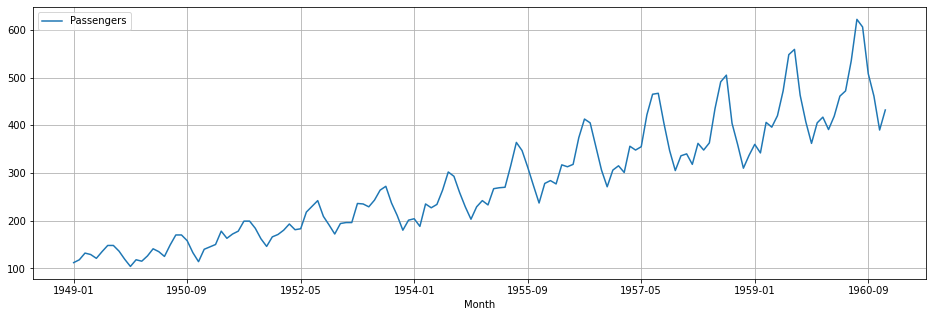

In [8]:
df.plot( figsize = (16,5))

plt.grid('On')
plt.show()

In [9]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [10]:
df['day'] = pd.to_datetime(df.index).dayofyear/366.0
df['year'] = pd.to_datetime(df.index).year - 1949
df.head()

,Passengers,day,year
Month,,,
1949-01,112,0.002732,0
1949-02,118,0.087432,0
1949-03,132,0.163934,0
1949-04,129,0.248634,0
1949-05,121,0.330601,0


In [11]:
data = df.copy()

In [12]:
data.head()

,Passengers,day,year
Month,,,
1949-01,112,0.002732,0
1949-02,118,0.087432,0
1949-03,132,0.163934,0
1949-04,129,0.248634,0
1949-05,121,0.330601,0


In [13]:
from numpy import asarray
from sklearn.preprocessing import StandardScaler
data_new = asarray(data['Passengers']).reshape(-1,1)
scaler = StandardScaler()
scaled = scaler.fit_transform(data_new)
data['Passengers'] = scaled

In [14]:
data.head()

,Passengers,day,year
Month,,,
1949-01,-1.407779,0.002732,0
1949-02,-1.357590,0.087432,0
1949-03,-1.240483,0.163934,0
1949-04,-1.265578,0.248634,0
1949-05,-1.332496,0.330601,0


In [15]:
data.shape

(144, 3)

In [16]:
# список признаков, по которым будем учить
#channelIndexes = [0,1, 2, 3] # BRENT
channelIndexes = [0,1,2]

# длина теста
valLen = 43
# длина истории для работы
xLen = 7
# отступ тестов от тренировок
bias = 1

# вычисляем точку разделения ряда на тесты и тренировку
train_split = 100
# делим
train_data = data.iloc[0 : train_split ,channelIndexes]
val_data = data.iloc[train_split:,channelIndexes]

In [17]:
train_data.head(3)

,Passengers,day,year
Month,,,
1949-01,-1.407779,0.002732,0
1949-02,-1.357590,0.087432,0
1949-03,-1.240483,0.163934,0


In [18]:
# шаг по данным для построения обучающих примеров
step = 1

# длина прошлого 
past = xLen
p = past
# горизонт предсказания
future = 1
h=future

# параметры модели для обучения
learning_rate = 0.001
batch_size = 16
epochs = 10

In [19]:
Chanel_numb = len(channelIndexes)

start = xLen + future
end = start + train_split-1

xTrain_df = train_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xTrain = xTrain_df[[train_data.columns[i] for i in range(Chanel_numb)]].values
yTrain = train_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

sequence_length = int(xLen / step)


x_end = len(val_data) - xLen - future 

label_start = len(train_data)+bias+xLen + future +1

xVal_df = val_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xVal = xVal_df[[val_data.columns[i] for i in range(Chanel_numb)]].values
yVal = val_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

In [20]:
print(xTrain.shape)

print(yTrain.shape)


print(xVal.shape)

print(yVal.shape)

(93, 3)
(93,)
(37, 3)
(37,)


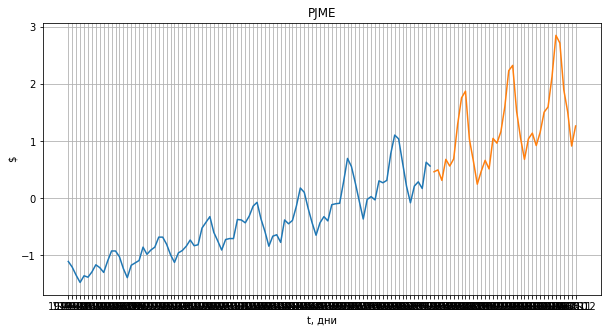

In [21]:
plt.figure(figsize=(10,5))
plt.plot(data.index[xLen:yTrain.shape[0]+xLen],yTrain[:])
plt.plot(data.index[yTrain.shape[0]+bias+future+2*xLen-2:],yVal[:])
plt.grid('on')
plt.xlabel('t, дни')
plt.ylabel('$')
#plt.title('стоимость BRENT в 2010-2018')
plt.title('PJME')
plt.show()

In [22]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    xTrain,
    yTrain,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    xVal,
    yVal,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)

In [23]:
for batch in dataset_val.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (15, 7, 3)
Target shape: (15,)


In [24]:
inputs[0,:,0]

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([1.03473342, 0.65831886, 0.24844523, 0.47429396, 0.66668363,
       0.5161178 , 1.05146296])>

In [25]:
targets[0]

<tf.Tensor: shape=(), dtype=float64, numpy=0.9678152781941977>

In [26]:
logdir = os.path.join("logs2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard( logdir, histogram_freq=1)

Epoch 1/10
6/6 [==============================] - 5s 234ms/step - loss: 0.6917 - mae: 0.7048 - val_loss: 2.1485 - val_mae: 1.3489
Epoch 2/10
6/6 [==============================] - 0s 45ms/step - loss: 0.2998 - mae: 0.4739 - val_loss: 0.6012 - val_mae: 0.5860
Epoch 3/10
6/6 [==============================] - 0s 45ms/step - loss: 0.2834 - mae: 0.4762 - val_loss: 0.4691 - val_mae: 0.5158
Epoch 4/10
6/6 [==============================] - 0s 44ms/step - loss: 0.1091 - mae: 0.2700 - val_loss: 0.4409 - val_mae: 0.5061
Epoch 5/10
6/6 [==============================] - 0s 45ms/step - loss: 0.1031 - mae: 0.2634 - val_loss: 0.3338 - val_mae: 0.4912
Epoch 6/10
6/6 [==============================] - 0s 43ms/step - loss: 0.1085 - mae: 0.2621 - val_loss: 0.3239 - val_mae: 0.4644
Epoch 7/10
6/6 [==============================] - 0s 47ms/step - loss: 0.0788 - mae: 0.2246 - val_loss: 0.4039 - val_mae: 0.4808
Epoch 8/10
6/6 [==============================] - 0s 45ms/step - loss: 0.0751 - mae: 0.2204 - va

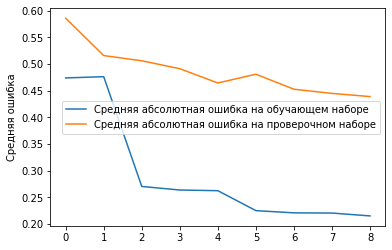

In [27]:
callbaсk = EarlyStopping(monitor='val_mae', patience=2)

model = Sequential()

model.add(LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(64, return_sequences="True")) # <None, 3,32>
model.add(Conv1D(64, 3, activation="linear")) #(None,3,64)
#model.add(Conv1D(64, 1, activation="linear"))
model.add(Flatten())                          # (None, 3*64)
model.add(Dense(3, activation="linear"))      # (None,3)

model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callbaсk, tensorboard_callback])


plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [28]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

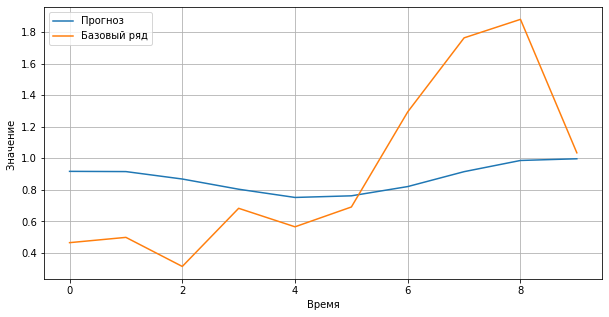

In [29]:
start = 0
step = 10
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[start:start+step], 
         label='Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

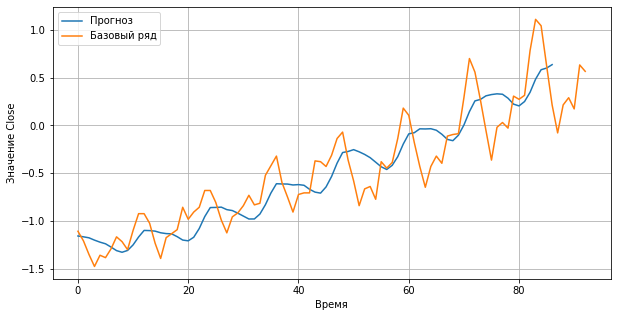

In [30]:
start = 0


plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred[start:train_split], 
         label='Прогноз')
plt.plot(yTrain.flatten()[start:train_split], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()